In [2]:
import string
import time
import json
import pickle
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from util import JSONParser
import tkinter as tk
from tkinter import ttk
from tkinter import simpledialog as simpledialog
from tkinter import messagebox as messagebox
import cv2
from PIL import Image, ImageTk
import re as regex
from sympy import *
from sympy import simplify
from collections import deque
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from concurrent.futures import ThreadPoolExecutor
from functools import lru_cache
from math import *
import random

class Marquee(tk.Canvas):
    def __init__(self, parent, text, width, height, speed=-2, **kw):
        super().__init__(parent, **kw)
        self.speed = speed
        self.text = text

        self.label = tk.Label(self, text=text, font=('Arial Rounded', 15), fg="black", bg="dark grey")
        self.update_idletasks()
        self.configure(width=width, height=height, highlightthickness=0)
        
        # Mengatur posisi awal label di tengah-tengah secara horizontal
        initial_x = (width - self.label.winfo_reqwidth()) // 2
        initial_y = (height - self.label.winfo_reqheight()) // 2

        self.create_window(initial_x, initial_y, window=self.label, anchor='nw', tags=("text",))
        self.after(0, self.scroll)

    def scroll(self):
        self.move("text", self.speed, 0)
        if self.bbox("text")[0] + self.label.winfo_reqwidth() <= 0:  # Ubah kondisi di sini
            self.move("text", self.label.winfo_reqwidth() + self.winfo_width(), 0)
        self.after(10, self.scroll)

    def destroy_marquee(self):
        self.destroy()

# Fungsi dengan memoisasi untuk lematisasi kata
@lru_cache(maxsize=None)
def stem_word(stemmer, word):
    return stemmer.stem(word)

# Fungsi praproses data dengan memoisasi
@lru_cache(maxsize=None)
def preprocess(chat):
    # Konversi ke non kapital
    chat = chat.lower()
    # Hilangkan tanda baca
    translator = str.maketrans('', '', string.punctuation)
    chat = chat.translate(translator)
    # Pecah teks menjadi kata-kata
    chat = chat.split()
    # Lematisasi kata-kata (Menghilangkan imbuhan kata)
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    
    # Paralelisasi lematisasi dengan memoisasi menggunakan list comprehension
    with ThreadPoolExecutor() as executor:
        chat = ' '.join([executor.submit(stem_word, stemmer, word).result() for word in chat])
    
    return chat

print("[INFO] Sabar sebentar ya kak, aku lagi belajar ...")

# Inisialisasi variabel global
asking_name = False
user_name = None

def bot_therapist_response(chat):
    global asking_name
    global user_name
    # Pola pertanyaan dan tanggapan
    therapist_responses = {
    r'aku merasa (.*)': [
        'Kenapa kamu merasa {0}, ' + user_name + '?',
        'Apa yang membuat kamu merasa {0}, ' + user_name + '?',
        'Berapa lama kamu merasa {0}, ' + user_name + '?'],
    r'apa yang membuatku merasa (.*)': [
        'Apakah ada hal atau situasi tertentu yang membuat kamu merasa {0}, ' + user_name + '?',
        'Apakah kamu bisa menjelaskan lebih detail mengenai faktor-faktor yang mempengaruhi perasaanmu {0}, ' + user_name + '?'],
    r'kenapa aku merasa (.*)': [
        'Apakah ada alasan spesifik mengapa kamu merasa {0}, ' + user_name + '?',
        'Apakah ada peristiwa atau perubahan dalam hidupmu yang berhubungan dengan perasaan {0}, ' + user_name + 'mu?'],
    r'mengapa (.*)': [
        'Apakah kamu yakin bahwa {0}, ' + user_name + '?',
        'Apa sebenarnya yang kamu tanyakan, apakah ada pertanyaan lain, ' + user_name + '?',
        'Apakah pertanyaan tersebut sangat penting buat kamu, ' + user_name + '?'],
    r'apa sebenarnya yang aku rasakan': [
        'Penting bagi kamu, ' + user_name + ', untuk menyadari dan mengakui perasaanmu sendiri. Apa yang membuatmu bingung tentang perasaanmu?',
        'Mungkin kamu bisa mencoba merenung sejenak dan mengidentifikasi perasaan yang ada dalam dirimu, ' + user_name + '.'],
    r'aku (.*) kamu': [
        'Bicarakan lebih lanjut mengenai perasaanmu terhadap saya, ' + user_name + '.',
        'Apakah ada hal khusus yang membuatmu merasa demikian terhadap saya, ' + user_name + '?'],
    r'apa yang harus aku lakukan': [
        'Pertanyaan itu mungkin tergantung pada situasinya, ' + user_name + '. Bisakah kamu memberikan lebih banyak konteks atau detail?',
        'Pertama-tama, cobalah untuk tenang dan mengevaluasi situasinya dengan objektif, ' + user_name + '. Setelah itu, kamu dapat membuat keputusan yang lebih baik.'],
    r'apa yang harus aku lakukan jika (.*)': [
        'Setiap situasi memiliki cara yang berbeda untuk ditangani, ' + user_name + '. Bisakah kamu memberikan lebih banyak informasi tentang situasi tersebut?',
        'Penting untuk mempertimbangkan konteks dan konsekuensi sebelum membuat keputusan, ' + user_name + '. Ceritakan lebih banyak tentang situasinya.'],
    r'aku sedang jatuh cinta dengan (.*)': [
        'Bagaimana perasaanmu ketika berada di dekat {0}, ' + user_name + '?',
        'Apa yang membuatmu tertarik pada {0}, ' + user_name + '?',
        'Ceritakan lebih banyak tentang perasaan cintamu terhadap {0}, ' + user_name + '.'],
    r'aku lagi naksir sama (.*)': [
        'Apa yang menarik dari {0} yang membuatmu naksir, ' + user_name + '?',
        'Apakah kamu pernah mencoba berinteraksi dengan {0} secara langsung, ' + user_name + '?',
        'Bagaimana perasaanmu ketika melihat {0}, ' + user_name + '?'],
    r'aku lagi jatuh cinta sama (.*)': [
        'Apakah {0} menyadari perasaanmu, ' + user_name + '?',
        'Apa yang membuatmu jatuh cinta pada {0}, ' + user_name + '?',
        'Bagaimana perasaanmu ketika berpikir tentang {0}, ' + user_name + '?'],
    r'gw suka banget sama (.*)': [
        'Apa yang membuatmu suka banget dengan {0}, ' + user_name + '?',
        'Apakah kamu berharap untuk memiliki hubungan khusus dengan {0}, ' + user_name + '?',
        'Ceritakan lebih banyak tentang perasaan suka bangetmu terhadap {0}, ' + user_name + '.'],
    r'gw naksir banget sama (.*)': [
        'Apakah kamu memiliki kesempatan untuk berbicara atau berteman dengan {0}, ' + user_name + '?',
        'Apa yang paling menarik dari {0} yang membuatmu naksir banget, ' + user_name + '?',
        'Bagaimana perasaanmu ketika melihat {0}, ' + user_name + '?'],
    r'saya (.*)': [
        'Ceritakan lebih lanjut tentang pengalamanmu sebagai {0}, ' + user_name + '.',
        'Apa yang membuatmu merasa {0}, ' + user_name + '?',
        'Bagaimana perasaanmu ketika menjadi {0}, ' + user_name + '?',
        'Berapa lama kamu merasa {0}, ' + user_name + '?'],
    r'saya sedang (.*)': [
        'Apakah ada alasan khusus mengapa kamu sedang {0}, ' + user_name + '?',
        'Bagaimana perasaanmu ketika sedang {0}, ' + user_name + '?',
        'Apa yang membuatmu merasa {0} saat ini, ' + user_name + '?',
        'Berapa lama kamu merasa {0}, ' + user_name + '?'],
    r'aku sedang (.*)': [
        'Bagaimana perasaanmu ketika sedang {0}, ' + user_name + '?',
        'Apakah ada hal yang mempengaruhi perasaan {0}mu, ' + user_name + '?',
        'Ceritakan lebih banyak tentang pengalamanmu saat sedang {0}, ' + user_name + '.',
        'Berapa lama kamu merasa {0}, ' + user_name + '?'],
    r'gw lagi (.*)': [
        'Apa yang membuatmu sedang {0}, ' + user_name + '?',
        'Bagaimana perasaanmu ketika lagi {0}, ' + user_name + '?',
        'Ceritakan lebih lanjut tentang pengalamanmu saat lagi {0}, ' + user_name + '.',
        'Berapa lama kamu merasa {0}, ' + user_name + '?'],
    r'saya lagi (.*)': [
        'Apakah ada alasan tertentu mengapa kamu lagi {0}, ' + user_name + '?',
        'Bagaimana perasaanmu ketika lagi {0}, ' + user_name + '?',
        'Apa yang membuatmu merasa {0} saat ini, ' + user_name + '?',
        'Berapa lama kamu merasa {0}, ' + user_name + '?'],
    r'aku lagi (.*)': [
        'Bagaimana perasaanmu ketika lagi {0}, ' + user_name + '?',
        'Apakah ada faktor yang berkontribusi pada perasaan {0}mu, ' + user_name + '?',
        'Ceritakan lebih banyak tentang pengalamanmu saat lagi {0}, ' + user_name + '.',
        'Berapa lama kamu merasa {0}, ' + user_name + '?'],
    r'nggak tau kenapa (.*)': [
        'Mungkin kamu perlu sedikit waktu untuk merenung dan memahami perasaanmu terhadap {0}, ' + user_name + '.',
        'Tidak apa-apa jika kamu tidak tahu alasan pasti, tapi coba perhatikan perasaanmu ketika berada di sekitar {0}, ' + user_name + '.',
        'Terkadang, kita tidak tahu dengan pasti mengapa kita merasakan sesuatu. Bagaimana perasaanmu ketika memikirkan {0}, ' + user_name + '?'],
    r'gak tau kenapa merasa (.*)': [
        'Mungkin kamu bisa mencoba mengidentifikasi situasi atau faktor-faktor tertentu yang mungkin mempengaruhi perasaanmu terhadap {0}, ' + user_name + '.',
        'Tidak apa-apa jika kamu tidak mengetahui alasan pasti. Cobalah untuk menjelajahi perasaanmu lebih dalam saat berada di sekitar {0}, ' + user_name + '.',
        'Kadang-kadang, perasaan datang tanpa alasan yang jelas. Bagaimana perasaanmu ketika memikirkan {0}, ' + user_name + '?'],
    r'gak tau': [
        'Mungkin kamu bisa merenung sejenak untuk mencari tahu apa yang sedang kamu rasakan atau alasan di balik perasaanmu, ' + user_name + '.',
        'Tidak apa-apa jika kamu tidak tahu, tapi cobalah untuk lebih memahami perasaanmu dengan mengamati situasi atau faktor-faktor yang mungkin mempengaruhinya.',
        'Terkadang, perasaan kita membutuhkan waktu untuk dipahami. Bagaimana kamu menggambarkan perasaanmu saat ini, ' + user_name + '?'],
    r'lagi (.*) aja': [
        'Apa yang membuatmu memilih untuk tetap {0}, ' + user_name + '?',
        'Apakah ada alasan khusus yang membuatmu memilih untuk terus {0}, ' + user_name + '?',
        'Bagaimana perasaanmu ketika sedang {0}, ' + user_name + '?'],
    r'nggak tau': [
        'Jika kamu merasa bingung, mungkin kamu bisa mencoba merenung sejenak dan mencari tahu apa yang sedang kamu rasakan, ' + user_name + '.',
        'Tidak apa-apa jika kamu tidak tahu, tapi cobalah untuk lebih memahami perasaanmu dengan mengamati situasi atau faktor-faktor yang mungkin mempengaruhinya.',
        'Kadang-kadang, kita membutuhkan waktu untuk memahami perasaan kita dengan lebih baik. Bagaimana kamu menggambarkan perasaanmu saat ini, ' + user_name + '?'],
    r'tidak mau': [
        'Baik, jika kamu tidak ingin bercerita lebih banyak, itu tidak masalah, ' + user_name + '. Apakah ada hal lain yang ingin kamu diskusikan?',
        'Jika kamu tidak ingin membicarakannya, tidak masalah. Apakah ada topik lain yang ingin kamu ajukan?',
        'Tidak apa-apa jika kamu tidak mau bercerita lebih banyak. Apakah ada hal lain yang ingin kamu sampaikan atau diskusikan?'],
    r'gak mau': [
        'Baik, jika kamu tidak mau, itu tidak masalah, ' + user_name + '. Apakah ada hal lain yang ingin kamu diskusikan?',
        'Jika kamu tidak mau, tidak masalah. Apakah ada topik lain yang ingin kamu ajukan?',
        'Tidak apa-apa jika kamu tidak mau. Apakah ada hal lain yang ingin kamu sampaikan atau diskusikan?'],
    r'gak': [
        'Jika kamu tidak ingin, itu tidak masalah, ' + user_name + '. Apakah ada hal lain yang ingin kamu diskusikan?',
        'Jika kamu tidak ingin, tidak masalah. Apakah ada topik lain yang ingin kamu ajukan?',
        'Tidak apa-apa jika kamu tidak ingin. Apakah ada hal lain yang ingin kamu sampaikan atau diskusikan?'],
    r'nggak': [
        'Baik, jika kamu nggak ingin, itu tidak masalah, ' + user_name + '. Apakah ada hal lain yang ingin kamu diskusikan?',
        'Jika kamu nggak ingin, tidak masalah. Apakah ada topik lain yang ingin kamu ajukan?',
        'Tidak apa-apa jika kamu nggak ingin. Apakah ada hal lain yang ingin kamu sampaikan atau diskusikan?'],
    r'tidak': [
        'Jika kamu tidak ingin, itu tidak masalah, ' + user_name + '. Apakah ada hal lain yang ingin kamu diskusikan?',
        'Jika kamu tidak ingin, tidak masalah. Apakah ada topik lain yang ingin kamu ajukan?',
        'Tidak apa-apa jika kamu tidak ingin. Apakah ada hal lain yang ingin kamu sampaikan atau diskusikan?'],
    r'aku (.*) sekali': [
        'Bagaimana perasaanmu saat menjadi {0} sekali, ' + user_name + '?',
        'Apa yang membuatmu merasa sangat {0}, ' + user_name + '?',
        'Ceritakan lebih banyak tentang perasaanmu yang sangat {0}, ' + user_name + '.'],
    r'saya (.*) sekali': [
        'Apa yang membuatmu jadi {0} sekali, ' + user_name + '?',
        'Apa yang membuatmu merasa sangat {0}, ' + user_name + '?',
        'Ceritakan lebih banyak tentang perasaanmu yang sangat {0}, ' + user_name + '.'],
    r'aku (.*) banget': [
        'Apa yang membuatmu merasa sangat {0}, ' + user_name + '?',
        'Bagaimana perasaanmu ketika menjadi {0} banget, ' + user_name + '?',
        'Ceritakan lebih banyak tentang perasaanmu yang sangat {0}, ' + user_name + '.'],
    r'saya (.*) banget': [
        'Apa yang membuatmu merasa sangat {0}, ' + user_name + '?',
        'Bagaimana perasaanmu ketika menjadi {0} banget, ' + user_name + '?',
        'Ceritakan lebih banyak tentang perasaanmu yang sangat {0}, ' + user_name + '.'],
    r'aku tadi dijahati oleh (.*)': [
        'Itu pasti pengalaman yang sulit, ' + user_name + '. Bagaimana kamu merasa setelah dijahati oleh {0}?',
        'Apa yang membuatmu merasa dijahati oleh {0}, ' + user_name + '?',
        'Ceritakan lebih banyak tentang pengalamanmu ketika dijahati oleh {0}, ' + user_name + '.'],
    r'aku tadi dijahati sama (.*)': [
        'Itu pasti pengalaman yang sulit, ' + user_name + '. Bagaimana kamu merasa setelah dijahati oleh {0}?',
        'Apa yang membuatmu merasa dijahati oleh {0}, ' + user_name + '?',
        'Ceritakan lebih banyak tentang pengalamanmu ketika dijahati oleh {0}, ' + user_name + '.'],
    r'aku tadi melihat (.*)': [
        'Bagaimana perasaanmu setelah melihat {0}, ' + user_name + '?',
        'Apakah melihat {0} mempengaruhi emosimu, ' + user_name + '?',
        'Ceritakan lebih banyak tentang pengalamanmu ketika melihat {0}, ' + user_name + '.'],
    r'aku tadi lihat (.*) di kamar mandi': [
        'Itu pasti pengalaman yang mengejutkan, ' + user_name + '. Bagaimana kamu merasa setelah melihat {0} di kamar mandi?',
        'Apa yang ada dalam pikiranmu saat melihat {0} di kamar mandi, ' + user_name + '?',
        'Ceritakan lebih banyak tentang pengalamanmu saat melihat {0} di kamar mandi, ' + user_name + '.'],
    r'ya aku (.*)': [
        'Maaf jika ada yang membuatmu kesal, ' + user_name + '. Bagaimana saya bisa membantu kamu dalam hal ini?',
        'Apa yang membuatmu merasa seperti itu, ' + user_name + '?',
        'Ceritakan lebih lanjut tentang perasaanmu saat menjadi {0}, ' + user_name + '.'],
    r'ya gw (.*)': [
        'Maaf jika ada yang membuatmu kesal, ' + user_name + '. Apakah ada yang bisa saya bantu?',
        'Apa yang membuatmu merasa seperti itu, ' + user_name + '?',
        'Ceritakan lebih lanjut tentang perasaanmu saat menjadi {0}, ' + user_name + '.'],
    r'ya begitulah': [
        'Saya minta maaf jika ada yang membuatmu kesal, ' + user_name + '. Apakah ada yang bisa saya bantu?',
        'Apa yang membuatmu merasa seperti itu, ' + user_name + '?',
        'Ceritakan lebih lanjut tentang perasaanmu saat mengatakan begitu, ' + user_name + '.'],
    r'yagitu': [
        'Maaf jika ada yang membuatmu kesal, ' + user_name + '. Apakah ada yang bisa saya bantu?',
        'Apa yang membuatmu merasa seperti itu, ' + user_name + '?',
        'Ceritakan lebih lanjut tentang perasaanmu saat mengatakan begitu, ' + user_name + '.'],
    r'ya gitu': [
        'Saya minta maaf jika ada yang membuatmu kesal, ' + user_name + '. Bagaimana saya bisa membantu kamu?',
        'Apa yang membuatmu merasa seperti itu, ' + user_name + '?',
        'Ceritakan lebih lanjut tentang perasaanmu saat mengatakan begitu, ' + user_name + '.'],
    r'bodo amat lah': [
        'Maaf jika ada yang membuatmu kesal, ' + user_name + '. Apakah ada yang bisa saya bantu?',
        'Bagaimana saya bisa membantu kamu, ' + user_name + '?',
        'Ceritakan lebih lanjut tentang perasaanmu saat mengatakan begitu.'],
    r'hahaha': [
        'Maaf jika ada yang membuatmu kesal, ' + user_name + '. Apakah ada yang bisa saya bantu?',
        'Saya minta maaf jika ada yang tidak lucu. Apakah ada yang ingin kamu sampaikan atau diskusikan, ' + user_name + '?'],
    r'karena (.*)': [
        'Mengapa {0} membuatmu merasa seperti itu, ' + user_name + '?',
        'Bagaimana perasaanmu ketika mengalami {0}?',
        'Ceritakan lebih lanjut tentang hubungan antara {0} dan perasaanmu, ' + user_name + '.'],
    r'aku (.*) aja, mau ku-(.*) orang itu': [
        'Hm, perasaanmu terhadap {0} sangat kuat, ' + user_name + '. Namun, penting untuk menjaga keamanan dan menyelesaikan masalah dengan cara yang positif dan damai. Apakah ada cara lain yang bisa kamu pilih untuk mengatasi masalah ini?',
        'Saya mengerti bahwa kamu merasa ingin membalas dendam terhadap {1} karena {0}. Namun, penting untuk diingat bahwa balas dendam seringkali tidak membawa kebahagiaan jangka panjang. Apakah ada cara lain untuk menyelesaikan masalah ini tanpa kekerasan?',
        'Aku mendengar keinginanmu untuk membalas dendam terhadap {1} karena {0}. Namun, marilah kita mencari cara yang lebih positif untuk menyelesaikan masalah ini. Bagaimana pendapatmu?'],
    r'(?:aku )?(?:mau curhat|butuh teman curhat|pengen curhat|ingin curhat|curhat dong|curcol dong)': [
        'Tentu, aku di sini untuk mendengarkan. Silakan ceritakan apa yang sedang kamu rasakan, ' + user_name + '.',
        'Aku siap mendengarkan curhatanmu. Apa yang ingin kamu ceritakan?',
        'Jika kamu butuh teman curhat, aku di sini untukmu. Apa yang ingin kamu sampaikan?',
        'Aku siap mendengarkan curhatanmu, ' + user_name + '. Silakan ceritakan apa yang sedang membuatmu gelisah atau stres.',
        'Saat kamu siap, ceritakan apa yang ingin kamu curhatkan. Aku di sini untuk mendengarkan.'],
    r'(?:aku )?(?:sedang panik|panik|gelisah|depresi|stres|lagi stres|lagi gelisah|lagi kesal|kesal|putus asa|cemas|sedih|marah|frustrasi|tertekan|terbebani|khawatir|kecewa|sakit hati|takut|malu|frustrasi|bingung|lelah|sia-sia|kecewa|bosan|jengkel|tersinggung)': [
        'Aku mendengar kamu sedang mengalami perasaan {0}, ' + user_name + '. Berceritalah lebih lanjut, aku di sini untuk mendengarkan.',
        'Jika kamu ingin mengungkapkan perasaan {0}, aku di sini untuk mendengarkan. Apa yang sedang kamu alami?',
        'Aku siap mendengarkan dan mendukungmu dalam menghadapi perasaan {0}, ' + user_name + '. Ceritakan lebih lanjut tentang apa yang sedang kamu rasakan.',
        'Aku di sini untukmu. Jika kamu ingin berbagi tentang perasaan {0} yang sedang terjadi, silakan ceritakan lebih lanjut.'],
    r'(?:ngomong apasih|dasar gaje|ye gaje|gajelas|dasar gajelas|ye gajelas|apasih goblok|gajelas tolol|gaje|gaje lu|apasih)': [
        'Maaf kalau responsku kurang memuaskan, ' + user_name + '. Apa yang sebenarnya ingin kamu ceritakan?',
        'Mungkin ada kesalahan dalam responsku, ' + user_name + '. Ceritakanlah lebih detail agar aku bisa lebih memahamimu.',
        'Saya minta maaf jika responsku tidak sesuai harapan, ' + user_name + '. Apa yang ingin kamu ceritakan?',
        'Aku minta maaf jika responsku tidak memuaskan, ' + user_name + '. Berceritalah lebih lanjut, aku di sini untuk mendengarkan.']
    }

    # default responses
    default_responses = [
    'Kok bisa begitu, ' + user_name + '?',
    'Coba ceritakan lebih dalam lagi, ' + user_name + '.',
    'Terus-terus, ' + user_name + '?',
    'Mau dong cerita lengkapnya, ' + user_name + '!',
    'Kok bisa begitu, ' + user_name + '? Aku jadi penasaran.',
    'Menurutmu kenapa bisa begitu, ' + user_name + '?',
    'Waduh, gimana tuh, ' + user_name + '?',
    'Kamu merasa apa tuh abis itu, ' + user_name + '?',
    'Kamu merasa gimana tuh abis itu, ' + user_name + '?',
    'Kamu merasa apa, ' + user_name + '?',
    'Kamu merasa gimana, ' + user_name + '?',
    'Terus gimana, ' + user_name + '?',
]

    # Menemukan pola pertanyaan yang cocok dengan inputan chat dan memberikan respons
    for pattern, responses in therapist_responses.items():
        match = regex.match(pattern, chat)
        if match is not None:
            response = random.choice(responses).format(*match.groups())
            return response

    # Jika tidak ada pola yang cocok, berikan respons default
    return random.choice(default_responses)

# fungsi untuk menampilkan teks dari respons bot secara gradual
def display_text_gradually(text_widget, text, delay=0.085, tag=None):
    text_widget.configure(state='normal')
    for char in text:
        text_widget.insert(tk.END, char, tag)  
        text_widget.update()
        time.sleep(delay)
    text_widget.configure(state='disabled')
    
def format_ribuan(angka):
    if angka == int(angka):  
        angka = int(angka)
        return f"{angka:,}".replace(",", "X").replace(".", ",").replace("X", ".")
    else:
        return f"{angka:,.2f}".replace(",", "X").replace(".", ",").replace("X", ".")


def replace_operator(match):
    operators = {
        "dikali": "*",
        "kali": "*",
        "x": "*",
        "X": "*",
        "dibagi": "/",
        "bagi": "/",
        ":": "/", 
        "ditambah": "+",
        "tambah": "+",
        "dikurangi": "-",
        "kurang": "-",
        "mod": "%"
    }
    return operators[match.group()]  

def kalkulator(expr):
    try:
        expression = regex.sub(r'\b(?:dikali|kali|[xX]|dibagi|bagi|ditambah|tambah|dikurangi|kurang|mod|:)\b', replace_operator, expr)  
        expression = regex.sub(r'\s+', '', expression)  # Menghapus spasi ekstra
        result = eval(expression)
        result_formatted = format_ribuan(result)
        return f"Hasil dari {expr} adalah {result_formatted}"
    except Exception as e:
        print(e)  # Tambahkan ini untuk melihat kesalahan yang terjadi
        return "Ekspresi matematika tidak valid"

def match_math_expression(chat):
    math_expr = regex.findall(r'\d+\s*(?:dikali|dibagi|ditambah|dikurangi|mod|kali|tambah|kurang|bagi|[xX\/*+\-:])\s*\d+', chat)  # Tambahkan : di sini
    return math_expr

# Membuat struktur data untuk menyimpan 3 pertanyaan terakhir
recent_questions = deque(maxlen=3)

therapist_mode = False  # variabel global untuk mengetahui apakah mode therapist aktif atau tidak

def bot_response(chat, pipeline, jp):
    global recent_questions
    global therapist_mode
    global user_name
    global asking_name
    recent_questions.append(chat)

    same_question_count = recent_questions.count(chat)

    if same_question_count == 3:
        return "Kenapa ngomong itu terus sih bang? Sekali lagi dapet piring cantik nih.", None
    else:
        math_expr = match_math_expression(chat)
        if math_expr:
            responses = []
            for expr in math_expr:
                response = kalkulator(expr)
                responses.append(response)

            # Gabungkan semua respons menjadi satu string
            response = ', '.join(responses)
            return response, None
        else:
            # Jika pengguna mengetikkan salah satu dari keyword berikut, aktifkan mode therapist dan balikkan ke bot_therapist_response
            therapist_keywords = ['therapist', 'aku mau curhat', 'aku mau curhat dong', 'aku butuh teman curhat',
                                  'curhat', 'mau curhat', 'pengen curhat', 'ingin curhat', 'curhat dong', 'curcol dong',
                                  'aku sedang panik', 'aku panik', 'aku gelisah', 'aku depresi', 'aku stres', 'aku lagi stres',
                                  'aku kesal', 'aku putus asa', 'aku cemas', 'aku sedih', 'aku marah', 'aku frustasi',
                                  'aku tertekan', 'aku terbebani', 'aku khawatir', 'aku kecewa', 'aku sakit hati', 'aku takut',
                                  'aku malu', 'aku bingung', 'aku lelah', 'aku sia-sia', 'aku bosan', 'aku jengkel', 'aku tersinggung',
                                  'aku kehilangan', 'aku merasa hampa', 'aku merasa sendirian', 'aku terluka', 'aku patah hati',
                                  'aku tidak berdaya', 'aku cemburu', 'aku gelap mata', 'aku frustrasi', 'aku kecewa pada diri sendiri',
                                  'aku merasa tidak berarti', 'aku tidak punya harapan', 'aku kelelahan', 'aku kesepian', 'aku merasa diabaikan',
                                  'aku merasa takut masa depan', 'aku khawatir tentang hidupku', 'aku bingung dengan diriku sendiri',
                                  'aku terjebak dalam keputusasaan', 'aku merasa tidak dicintai', 'aku merasa tidak diperhatikan',
                                  'aku merasa terasing', 'aku merasa tidak memiliki kendali', 'aku merasa terjebak dalam masalah',
                                  'aku merasa tidak bisa mengatasinya', 'aku merasa terpuruk',
                                  'gemes', 'galau', 'bete', 'mager', 'baper', 'kepo', 'gapapa', 'bingung', 'bosan', 'jenuh',
                                  'hancur', 'bodoh', 'sumpah', 'ciyee', 'gue', 'nangis', 'seneng', 'kece', 'asik', 'anxiety', 'gila',
                                  'cringe', 'awkward', 'mood', 'trigger', 'apatis', 'fomo', 'deadline', 'self-doubt', 'sks',
                                  'procrastination', 'sok cool', 'yasudahlah', 'capek', 'jijik', 'nyesek', 'santai', 'ambigu', 'bodo amat',
                                  'garing', 'gemesin', 'jatuh cinta', 'naksir', 'patah hati', 'ngebetein', 'nyesekin', 'ngebosenin',
                                  'bikin stres', 'capek banget', 'kepo banget', 'ga enak', 'keki', 'galau banget', 'gemes banget',
                                  'ingin curhat', 'ingin cerita', 'mau cerita', 'mau banget curhat', 'pengen banget cerita',]
            
            exit_keywords = ['terima kasih, jarwo', 'makasi', 'terima kasih', 'makasi jarwo', 'terima kasih, jarwo', 'makasi ya'
                             'makasi, jarwo', 'tq jarwo', 'tq', 'ya itu aja', 'ya begitu aja', 'ya udah gitu aja', 'udah gitu aja', 'daa', 'daaa', 'dadaaah',
                             'dadah', 'udah kayaknya gitu aja', 'udah kayaknya gitu aja deh', 'ya udah makasi', 'ya makasi', 'oke makasi', 'oke tq', 'oke terima kasih']
            
            if any(keyword in chat.lower() for keyword in therapist_keywords):
                therapist_mode = True
                if user_name is None:
                    asking_name = True
                    return "Hai, sebelumnya aku boleh tau nama kamu?", None
                else:
                    return bot_therapist_response(chat), None

            # Jika mode therapist aktif, gunakan fungsi bot_therapist_response untuk merespons
            elif therapist_mode:
                if asking_name:
                    name_regex = r'(?i)(namaku|nama|aku|saya|gw|nama gw|)\s*:?([a-zA-Z]*)'
                    match = regex.search(name_regex, chat)
                    if match:
                        user_name = match.group(2)  # mengambil grup kedua dari hasil regex, yaitu nama pengguna

                        # daftar penolakan pengguna
                        rejection_responses = ['tidak boleh', 'tidak', 'mau tau aja', 'gaboleh', 'ga', 'nggak', 'nggak boleh',
                                                'kepo', 'ngapain nanya2', 'ngapain nanya-nanya', 'ga boleh']

                        # Cek jika user_name ada dalam daftar penolakan
                        if user_name.lower() in rejection_responses:
                            user_name = "Kak"
                            asking_name = False
                            return "Baik, tidak apa-apa. Bagaimana aku bisa membantu kamu hari ini, kak?", None

                        asking_name = False
                        return "Senang bertemu denganmu, " + user_name + ". Bagaimana aku bisa membantu kamu hari ini?", None
                elif any(keyword in chat.lower() for keyword in exit_keywords):
                    therapist_mode = False
                    return "Senang bisa membantumu, "+ user_name, None
                else:
                    return bot_therapist_response(chat), None
            
            else:
                chat = preprocess(chat)
                res = pipeline.predict_proba([chat])
                max_prob = max(res[0])
                if max_prob < 0.19:
                    return "Maaf kak, aku ga ngerti :(", None
                else:
                    max_id = np.argmax(res[0])
                    pred_tag = pipeline.classes_[max_id]
                    return jp.get_response(pred_tag), pred_tag
                
# load data
path = "data/intents.json"
jp = JSONParser()
jp.parse(path)
df = jp.get_dataframe()
df['text_input_prep'] = df.text_input.apply(preprocess)

# pemodelan
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline = make_pipeline(TfidfVectorizer(ngram_range=(1, 3), min_df=2, max_df=0.9),
                         RandomForestClassifier(n_jobs=3))

# train
print("[INFO] Training Data ...")
pipeline.fit(df.text_input_prep, df.intents)

# save model
with open("model_chatbot.pkl", "wb") as model_file:
    pickle.dump(pipeline, model_file)
    
print("[INFO] Proses dekapitalisasi huruf sudah selesai")
print("[INFO] Proses penghilangan tanda baca sudah selesai")
print("[INFO] Proses pemecahan teks menjadi kata-kata sudah selesai")
print("[INFO] Proses lematisasi kata-kata sudah selesai")
print("\n[INFO] Program dimulai")

def update_intents_file(jp, chat, correct_tag, new_response):
    intent_data = jp.data
    found = False
    for intent in intent_data["intents"]:
        if intent["tag"] == correct_tag:
            if chat not in intent["patterns"]:
                intent["patterns"].append(chat)
            if new_response not in intent["responses"]:
                intent["responses"].append(new_response)
            found = True
            break
    if not found:
        intent_data["intents"].append({"tag": correct_tag, "patterns": [chat], "responses": [new_response]})

    with open("data/intents.json", "w") as outfile:
        json.dump(intent_data, outfile, indent=4)

# interaksi dengan bot
last_chat = None
last_last_chat = None

# fungsi inputasi dari dari user
def send_message(event=None):
    global last_chat, last_last_chat, df

    chat = entry_chat.get()
    entry_chat.delete(0, tk.END)

    last_last_chat = last_chat
    last_chat = chat

    res, tag = bot_response(chat, pipeline, jp)

    if chat.strip() != "":
        chat_history.configure(state='normal', font = ('Arial Rounded', 10))
        chat_history.tag_configure('margin', lmargin1=20, rmargin=20, lmargin2=60) 
        if chat_history.index('end-1c') == '1.0':  # Cek apakah ini pesan pertama
            chat_history.tag_configure('top_margin', lmargin1=20, rmargin=20, spacing1=10, lmargin2=60) 
            chat_history.insert(tk.END, "Ente  : " + chat + "\n", 'top_margin')  
        else:
            chat_history.insert(tk.END, "Ente  : " + chat + "\n", 'margin')

    if chat.lower() == 'clear':
        chat_history.configure(state='normal')
        chat_history.delete(1.0, tk.END)
        chat_history.configure(state='disabled')
        
    elif chat.lower() == 'fix' or 'apasih gaje' in chat.lower():
        correct_tag = tk.simpledialog.askstring("Jarwo", "Konteks pembicaraan:")
        if correct_tag is not None:
            # Ask user for response
            new_response = tk.simpledialog.askstring("Jarwo", f"Apa jawaban yang benar?")

            if new_response is not None:
                # Menambahkan input dari user ke dalam data set
                input_data = pd.DataFrame({'text_input': [last_last_chat], 'intents': [correct_tag]})
                df = pd.concat([df, input_data], ignore_index=True)

                # Update intents.json
                update_intents_file(jp, last_last_chat, correct_tag, new_response)

                # Reload the updated JSON data and update the DataFrame
                jp.parse(path)
                df = jp.get_dataframe()

                # Preprocess data
                df['text_input_prep'] = df.text_input.apply(preprocess)

                # Latih ulang model
                pipeline.fit(df.text_input_prep, df.intents)

                # Simpan model
                with open("model_chatbot.pkl", "wb") as model_file:
                    pickle.dump(pipeline, model_file)
                
                res = new_response
    else:
        chat_history.tag_configure('jarwo', foreground='dark blue', font=('Arial Rounded', 10), 
                                   lmargin1=20, rmargin=20, lmargin2=60) 
        chat_history.insert(tk.END, "Jarwo: ", 'jarwo')
        chat_history.see(tk.END)
        display_text_gradually(chat_history, res + "\n\n", tag='jarwo',)

        chat_history.configure(state='disabled')
        chat_history.see(tk.END)

    if tag is not None and tag.lower() == 'bye':
        root.quit()
        root.destroy()

root = tk.Tk()

#ini untuk icon
root.iconbitmap('jarwo.ico')

#ini untuk judul kecil di atas
root.title("JARWO - Your AI Assistant")

#ini untuk ukuran GUInya, bang
root.geometry("600x430")

#ini untuk warna GUInya, bang
root.configure(bg="black")

#ini untuk load video di awal ya, bang
video_source = r"C:\Users\Sebastian\Desktop\Kuliah\Semester 2\Pengantar Kecerdasan Buatan\TB_Chatbot\Chatbot_Sebastian\jarwo.mp4"
video_cap = cv2.VideoCapture(video_source)

# Pastikan sumber video dibuka
if not video_cap.isOpened():
    raise ValueError("Unable to open video source")

fps = video_cap.get(cv2.CAP_PROP_FPS)
max_frames = int(fps * 3.5)  #durasi video

stop_video = False

def update_video_frames(canvas, video_cap):
    global stop_video, max_frames

    if stop_video:
        return

    current_frame = int(video_cap.get(cv2.CAP_PROP_POS_FRAMES))

    if current_frame >= max_frames:
        video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    ret, frame = video_cap.read()

    if not ret:
        # Jika video berakhir, ulangi dari awal
        video_cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
    else:
        #Ubah setiap frame jadi gambar
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = Image.fromarray(frame)

        # Atur ukuran frame sesuai dengan ukuran canvas
        frame = frame.resize((canvas.winfo_width(), canvas.winfo_height()), Image.LANCZOS)

        frame = ImageTk.PhotoImage(frame)
        canvas.create_image(0, 0, image=frame, anchor=tk.NW)
        canvas.image = frame

    # Schedule the next frame update
    canvas.after(30, update_video_frames, canvas, video_cap)

#Tampilkan video
canvas = tk.Canvas(root, width=580, height=290, highlightthickness=0)
canvas.pack(pady=5)

#load video di sini
video_cap = cv2.VideoCapture('jarwo.mp4')

# Update the video frames on the canvas
update_video_frames(canvas, video_cap)


def on_closing():
    global video_cap
    video_cap.release()
    root.destroy()

root.protocol("WM_DELETE_WINDOW", on_closing)

# Fungsi untuk memulai chatbot
def start_chatbot():
    global chat_history, entry_chat, marquee

    # Hapus tombol start dan video awal
    marquee.destroy_marquee()
    button_start.destroy()
    #label_title.destroy()
    stop_video = True
    canvas.destroy()
    
    # Membuat loading bar
    style = ttk.Style()
    style.configure("big.Horizontal.TProgressbar", thickness=30)
    
    label_loading = tk.Label(root, text="LOADING CUY", font=("Boulder", 30),fg="white",bg="black")
    label_loading.pack(pady=100)
    label_loading1 = tk.Label(root, text="Loading ini tidak ada gunanya, biar keren saja", 
                              font=("Arial Rounded", 15),fg="white",bg="black")
    label_loading1.pack(pady=5)
    loading_bar = ttk.Progressbar(root, length=500, mode='determinate', maximum=100, style="big.Horizontal.TProgressbar")
    loading_bar.pack(pady=20)

    root.update()

    # Simulasi waktu loading dan update value
    loading_duration = 5  # Atur waktu loading di sini
    for i in range(100):
        loading_bar['value'] = i
        root.update()
        time.sleep(loading_duration / 100)

    # Hapus label loading dan loading bar
    loading_bar.destroy()
    label_loading.destroy()
    label_loading1.destroy()
    
    marquee = Marquee(root, "(INFO) Jika respons chatbot tidak sesuai konteks, ketik 'FIX' untuk memperbaiki respons dari chatbot. Ketik 'CLEAR' untuk menghapus history.",
                      width=600, height=35, bg="dark grey")
    marquee.pack(padx=20,pady=12)

    # Munculkan teks history
    chat_history = tk.Text(root, height=20, width=80, wrap=tk.WORD)
    chat_history.configure(state='disabled')
    entry_chat = tk.Entry(root, width=70)

    chat_history.pack(side=tk.TOP, padx=0, pady=0)
    entry_chat.pack(side=tk.LEFT, padx=85, pady=0)
    entry_chat.focus_set()

    entry_chat.bind('<Return>', send_message)

    # Buat pengumuman di chat history
    chat_history.configure(state='normal', font = ('Arial Rounded', 10))
    announcement = ""
    
    # Configure text tags for center alignment
    chat_history.tag_configure('center', justify='center')
    chat_history.tag_configure('red', foreground='red')

    # Insert the announcement text with the 'center' and 'red' tags
    chat_history.insert(tk.END, announcement, ('center', 'red'))
    chat_history.configure(state='disabled')
    
    chat_history.insert(tk.END, announcement, ('margin', 'red'))
    chat_history.configure(state='disabled')
    
button_start = tk.Button(root, text="      START      ", font=("Boulder", 30), bg="black", fg="white", 
                         borderwidth=0, relief="raised", command=lambda: start_chatbot())
button_start.pack(pady=5, padx=100)

marquee = Marquee(root, "Selamat datang di Chatbot Jarwo. Chatbot ini adalah tugas besar mata kuliah pengantar kecerdasan buatan yang dibuat oleh Sebastianus Lukito (41522110051) dan Bayu Randuaji Widodo (41522110016) yang diampu oleh Bapak Muhaimin Hasanudin", width=600, height=35, bg="dark grey")
marquee.pack(padx=20,pady=0)

root.mainloop()

[INFO] Sabar sebentar ya kak, aku lagi belajar ...
[INFO] Data JSON converted to DataFrame with shape : (439, 2)
[INFO] Training Data ...
[INFO] Proses dekapitalisasi huruf sudah selesai
[INFO] Proses penghilangan tanda baca sudah selesai
[INFO] Proses pemecahan teks menjadi kata-kata sudah selesai
[INFO] Proses lematisasi kata-kata sudah selesai

[INFO] Program dimulai


c:\Users\Sebastian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Sebastian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Akurasi: 55.68%
Presisi: 56.91%
Recall: 55.68%
F1 Score: 52.15%

Penjelasan:
Model berhasil memprediksi kelas dengan akurat 55.68% dari waktu.
Dari semua prediksi positif yang dibuat oleh model, 56.91% dari mereka adalah benar.
Model berhasil menemukan 55.68% dari semua kelas positif sebenarnya.
Model memiliki keseimbangan antara presisi dan recall sebesar 52.15%.


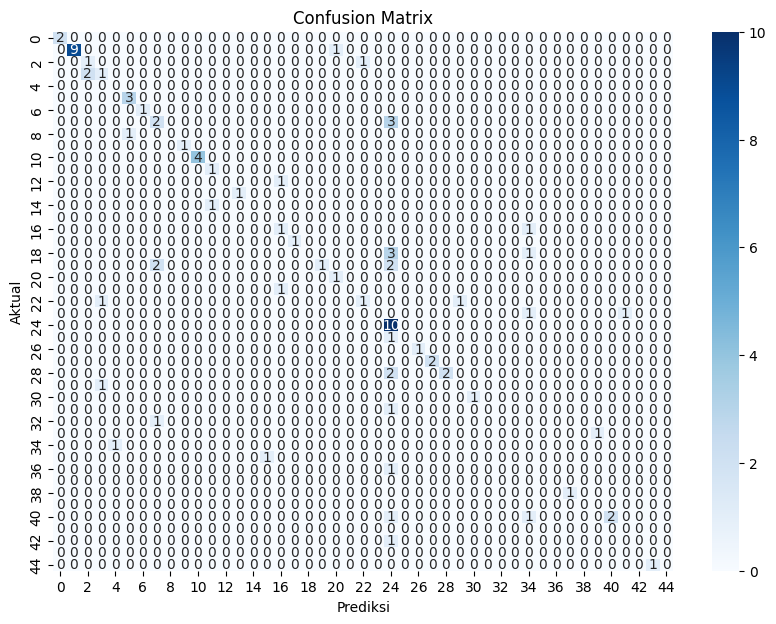

In [8]:
# Mengimpor library yang dibutuhkan
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# Membuka dan memuat data dari file intents.json
with open('data/intents.json', 'r') as file:
    data = json.load(file)

# Mengekstrak intent dan respons
intents = []
responses = []
for intent in data['intents']:
    for pattern in intent['patterns']:
        intents.append(pattern)
        responses.append(intent['responses'][0])  # menggunakan respons pertama untuk setiap intent

# Mengubah intent dan respons menjadi vektor numerik
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(intents) # mengubah teks intent menjadi vektor fitur dengan TF-IDF

encoder = LabelEncoder()
y = encoder.fit_transform(responses) # mengubah respons kategorikal menjadi label numerik

# Memisahkan data menjadi set latih dan set uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Melatih classifier RandomForest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Membuat prediksi
y_pred = clf.predict(X_test)

# Menghitung metrik evaluasi
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted') 
f1 = f1_score(y_test, y_pred, average='weighted') 

# Mengubah skor menjadi persentase
accuracy_perc = accuracy * 100
precision_perc = precision * 100
recall_perc = recall * 100
f1_perc = f1 * 100

# Menampilkan metrik evaluasi dalam persentase
print("Akurasi: {:.2f}%".format(accuracy_perc))
print("Presisi: {:.2f}%".format(precision_perc))
print("Recall: {:.2f}%".format(recall_perc))
print("F1 Score: {:.2f}%".format(f1_perc))

# Menampilkan penjelasan berdasarkan skor
print("\nPenjelasan:")
print("Model berhasil memprediksi kelas dengan akurat {:.2f}% dari waktu.".format(accuracy_perc))
print("Dari semua prediksi positif yang dibuat oleh model, {:.2f}% dari mereka adalah benar.".format(precision_perc))
print("Model berhasil menemukan {:.2f}% dari semua kelas positif sebenarnya.".format(recall_perc))
print("Model memiliki keseimbangan antara presisi dan recall sebesar {:.2f}%.".format(f1_perc))

# Menghitung dan menampilkan confusion matrix
confusion = confusion_matrix(y_test, y_pred)

# Plot confusion matrix menggunakan Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(confusion, annot=True, cmap='Blues')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()


In [2]:
jumlah_intents = len(jp.data["intents"])
print(jumlah_intents)

NameError: name 'jp' is not defined

In [1]:
for intent in jp.data["intents"]:
    tag = intent["tag"]
    patterns_count = len(intent["patterns"])
    responses_count = len(intent["responses"])
    print(f"{tag}: {patterns_count} patterns, {responses_count} responses")


NameError: name 'jp' is not defined

In [3]:
# train
print("[INFO] Training Data ...")
X_train = pipeline.named_steps['tfidfvectorizer'].fit_transform(df.text_input_prep)
pipeline.fit(df.text_input_prep, df.intents)

def text_to_numeric_vector(text, pipeline):
    text = preprocess(text)
    vectorizer = pipeline.named_steps['tfidfvectorizer']
    numeric_vector = vectorizer.transform([text])
    return numeric_vector

sample_text = "coba print data yang sudah dikonversi menjadi vektor numerik"
numeric_vector = text_to_numeric_vector(sample_text, pipeline)
print("Vektor numerik dari teks:", numeric_vector)

[INFO] Training Data ...


NameError: name 'pipeline' is not defined

In [9]:
import json

# Fungsi untuk mengambil semua teks dari intents.json
def get_sample_texts_from_intents(file_path):
    with open(file_path, "r") as json_file:
        data = json.load(json_file)
    sample_texts = []
    for intent in data["intents"]:
        sample_texts.extend(intent["patterns"])
    return sample_texts

# Menggunakan fungsi untuk mengambil sample teks dari intents.json
sample_texts = get_sample_texts_from_intents("data/intents.json")

# Menampilkan sample teks
for text in sample_texts:
    print(text)

Hai
Hi
Halo
Apa Kabar
Selamat Pagi
Selamat Siang
Selamat Malam
Salam
Ping
P
Hey
Hello
Ohayou
Konnichiwa
Syalom
Assalamualaikum
Salam Hangat
Salam Sejahtera
Om swastiastu
Salam Sukses
haiii
Dadah
Selamat Tinggal
Dah, bray
Dah, om
Dah, cuy
Daah
Semoga harimu menyenangkan
Ok makasih
Sampai jumpa lagi
Ok bye
Bye
Daaa
Daaah
Sampai jumpa
bye bye
nama kamu siapa?
lu siapa?
siapa sih lo?
lu sape ?
nama lo sape dah ?
nama?
Nama lu sapa?
sapa nih?
Ente siapa?
ente sape?
Ibu kota Indonesia apa, cuy?
Ibu kota Indonesia apa, bray?
Ibu kota Indonesia apa, om?
Ibu kota Indonesia apa, com?
Ibu kota Indonesia apa, kak?
Ibu kota Indonesia apa, kakak?
Ibu kota Indonesia
Ibu kota Indonesia apa?
Ibukota Indonesia apa?
Ibukota Indonesia?
Ibu kota Indonesia?
Ibukota Indonesia
Ibukota endonesa
lu ngapain?
pekerjaan lo apa?
Ngape lu?
ngapain lu?
ngapain lu dah?
ngapain lu sekarang?
ngapain lu hari ini?
lu kerja apa sih?
pekerjaan kamu apa?
lu kerja apa?
tugas kamu apa?
tugas lo ngapain?
What are you doing?
Wha